In [1]:
# !pip install kaggle

In [2]:
# from google.colab import drive
# drive.mount('/content/drive')

In [3]:
# ! mkdir ~/.kaggle

In [4]:
# !cp /content/drive/MyDrive/KAGGLE_API/kaggle.json ~/.kaggle/kaggle.json

In [5]:
# ! chmod 600 ~/.kaggle/kaggle.json

In [6]:
# ! kaggle datasets download -d dmitrybabko/speech-emotion-recognition-en

In [7]:
# !unzip speech-emotion-recognition-en.zip

## Library

In [8]:
import pandas as pd
import numpy as np
import pathlib

import os
import sys

import librosa
import librosa.display
import seaborn as sns
import matplotlib.pyplot as plt
import scipy
from scipy.signal import resample

from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import train_test_split

from IPython.display import Audio

import keras
from keras.callbacks import ReduceLROnPlateau, LearningRateScheduler
from keras.models import Sequential
from keras.layers import Dense, Conv1D, MaxPooling1D, Flatten, Dropout, BatchNormalization, LSTM
from keras.utils import to_categorical
from keras.callbacks import ModelCheckpoint

import warnings
if not sys.warnoptions:
    warnings.simplefilter("ignore")
warnings.filterwarnings("ignore", category=DeprecationWarning)

C:\Users\ricca\AppData\Local\Temp\ipykernel_13904\868833835.py:1: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


## Dataset

In [9]:
Tess = "./Tess/"
savee = ""

In [10]:
paths = []
labels = []

for dirname, _, filenames in os.walk(Tess):
    for filename in filenames:
        label = filename.split('_')[-1]
        label = label.split('.')[0]
        paths.append(os.path.join(dirname, filename))
        label = filename.split('_')[-1]
        label = label.split('.')[0]
        labels.append(label.lower())
print('Dataset is Loaded')

tess_directory_list = os.listdir(Tess)


Dataset is Loaded


In [11]:
df = pd.DataFrame({'path':paths, 'label':labels})

In [12]:
df.head()

,path,label
0,./Tess/OAF_angry\OAF_back_angry.wav,angry
1,./Tess/OAF_angry\OAF_bar_angry.wav,angry
2,./Tess/OAF_angry\OAF_base_angry.wav,angry
3,./Tess/OAF_angry\OAF_bath_angry.wav,angry
4,./Tess/OAF_angry\OAF_bean_angry.wav,angry


In [13]:
df.shape


(2800, 2)

## EDA

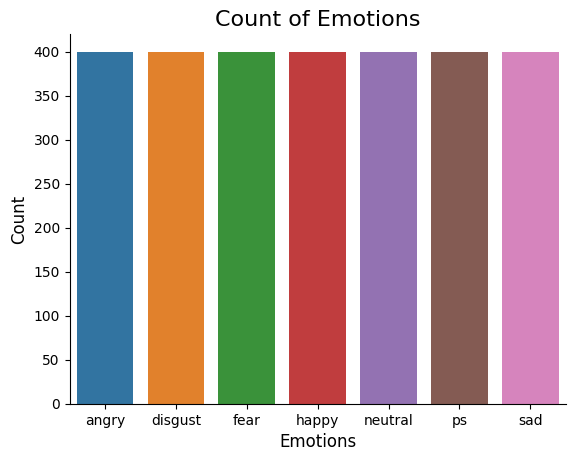

In [14]:
plt.title('Count of Emotions', size=16)
sns.countplot(x = df.label)
plt.ylabel('Count', size=12)
plt.xlabel('Emotions', size=12)
sns.despine(top=True, right=True, left=False, bottom=False)
plt.show()

In [15]:
def create_waveplot(data, sr, e):
    plt.figure(figsize=(10, 3))
    plt.title('Waveplot for audio with {} emotion'.format(e), size=15)
    librosa.display.waveshow(data, sr=sr)
    plt.show()

def create_spectrogram(data, sr, e):
    # stft function converts the data into short term fourier transform
    X = librosa.stft(data)
    Xdb = librosa.amplitude_to_db(abs(X))
    plt.figure(figsize=(12, 3))
    plt.title('Spectrogram for audio with {} emotion'.format(e), size=15)
    librosa.display.specshow(Xdb, sr=sr, x_axis='time', y_axis='hz')
    #librosa.display.specshow(Xdb, sr=sr, x_axis='time', y_axis='log')
    plt.colorbar()

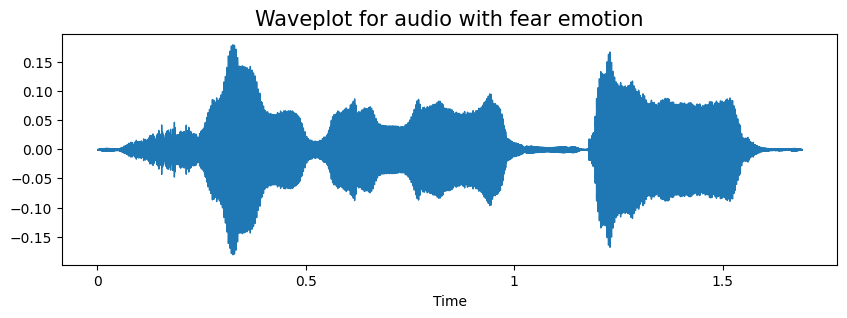

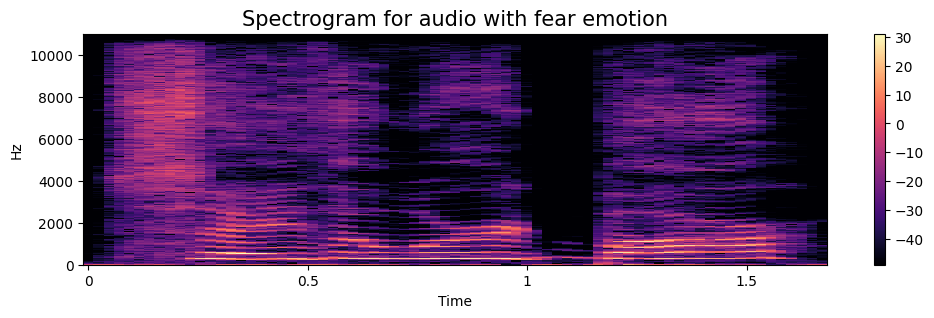

In [16]:
emotion='fear'
path = np.array(df.path[df.label==emotion])[1]
data, sampling_rate = librosa.load(path)
create_waveplot(data, sampling_rate, emotion)
create_spectrogram(data, sampling_rate, emotion)
Audio(path)

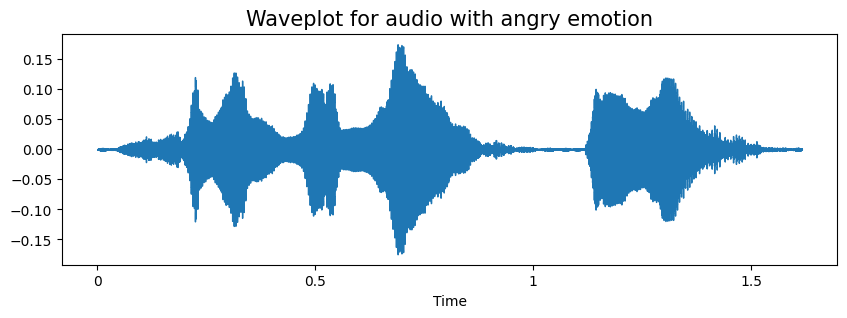

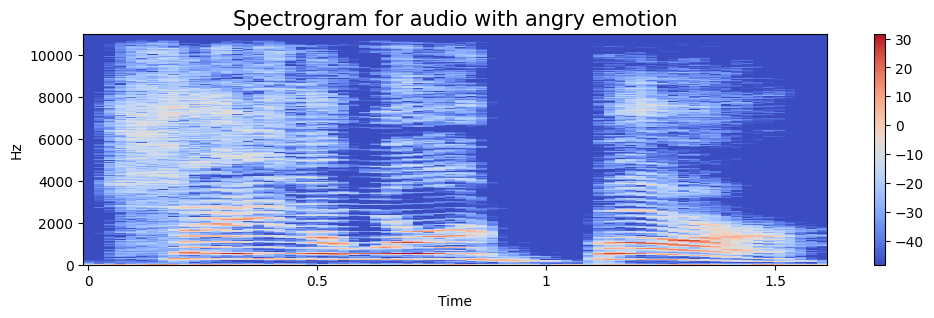

In [17]:
emotion='angry'
path = np.array(df.path[df.label==emotion])[1]
data, sampling_rate = librosa.load(path)
create_waveplot(data, sampling_rate, emotion)
create_spectrogram(data, sampling_rate, emotion)
Audio(path)

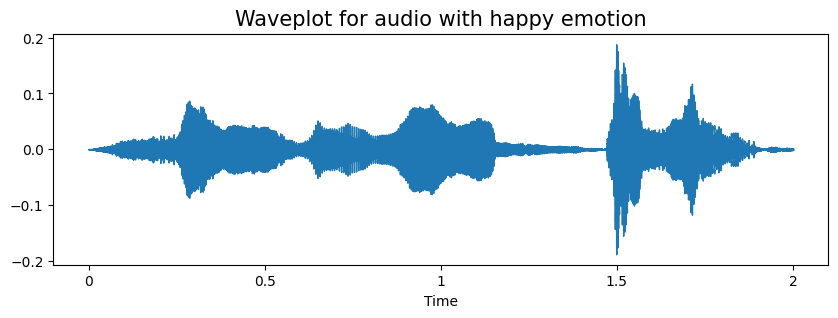

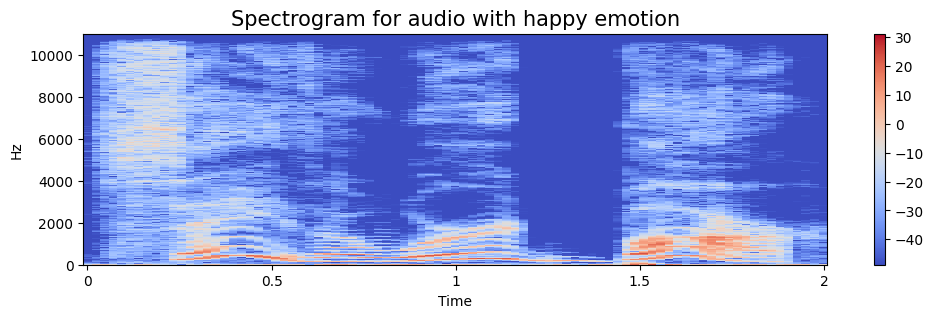

In [18]:
emotion='happy'
path = np.array(df.path[df.label==emotion])[1]
data, sampling_rate = librosa.load(path)
create_waveplot(data, sampling_rate, emotion)
create_spectrogram(data, sampling_rate, emotion)
Audio(path)

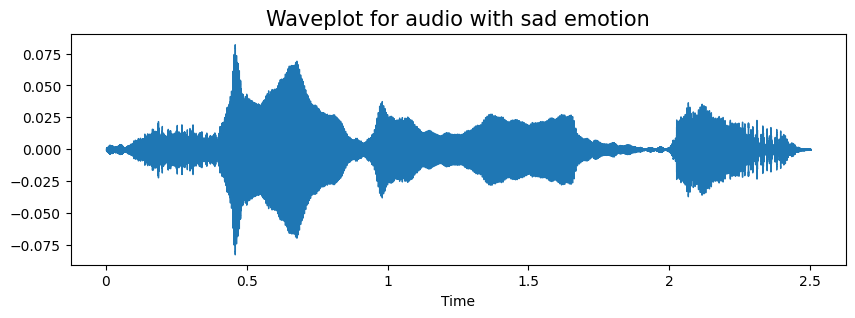

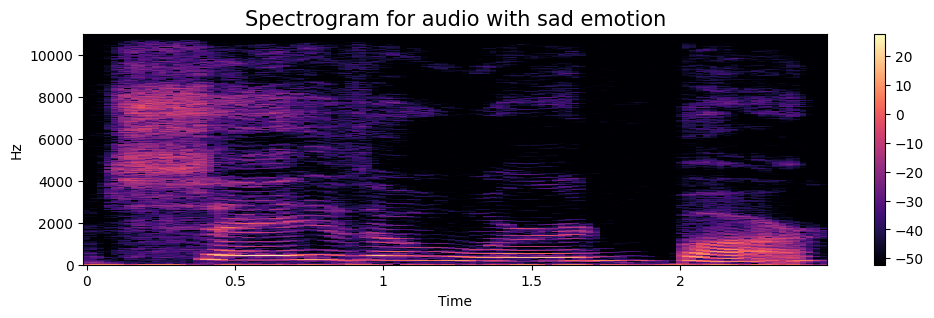

In [19]:
emotion='sad'
path = np.array(df.path[df.label==emotion])[1]
data, sampling_rate = librosa.load(path)
create_waveplot(data, sampling_rate, emotion)
create_spectrogram(data, sampling_rate, emotion)
Audio(path)

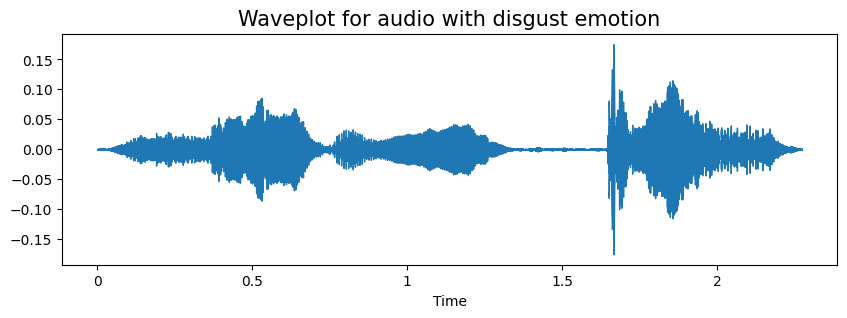

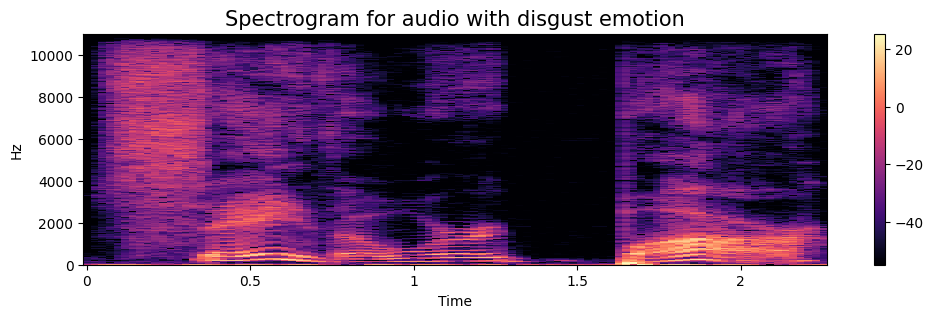

In [20]:
emotion='disgust'
path = np.array(df.path[df.label==emotion])[1]
data, sampling_rate = librosa.load(path)
create_waveplot(data, sampling_rate, emotion)
create_spectrogram(data, sampling_rate, emotion)
Audio(path)

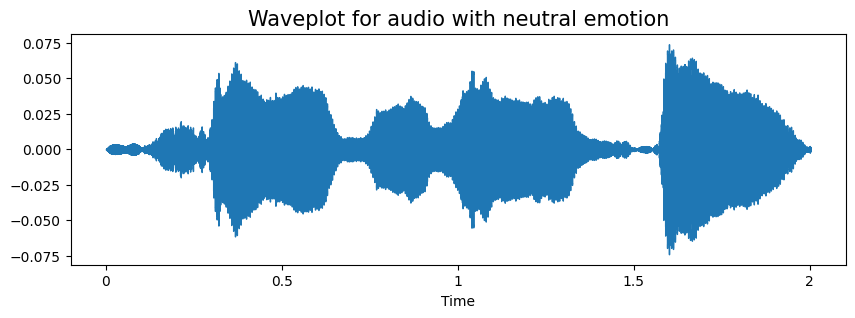

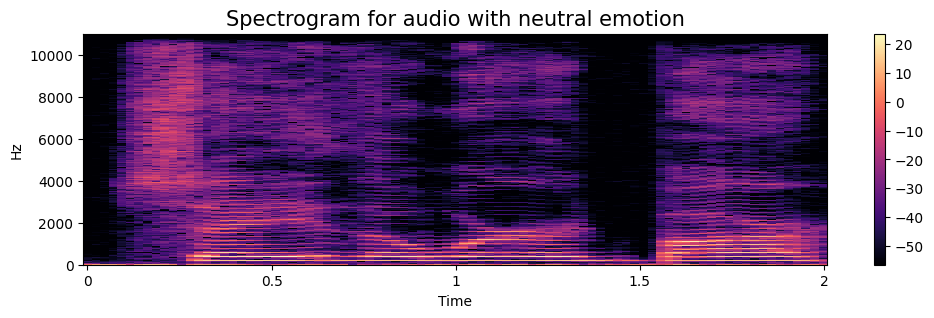

In [21]:
emotion='neutral'
path = np.array(df.path[df.label==emotion])[1]
data, sampling_rate = librosa.load(path)
create_waveplot(data, sampling_rate, emotion)
create_spectrogram(data, sampling_rate, emotion)
Audio(path)

In [22]:
def noise(data):
    noise_amp = 0.035*np.random.uniform()*np.amax(data)
    data = data + noise_amp*np.random.normal(size=data.shape[0])
    return data

def stretch(data, rate=0.8):
    return librosa.effects.time_stretch(data, rate=rate)

def shift(data):
    shift_range = int(np.random.uniform(low=-5, high = 5)*1000)
    return np.roll(data, shift_range)

def pitch(data, sampling_rate, pitch_factor=0.7):
    n_steps = 12 * pitch_factor  # Assuming 12 steps per octave
    return librosa.effects.pitch_shift(data, sr=sampling_rate, n_steps=n_steps)

path = np.array(df['path'])[1]
data, sample_rate = librosa.load(path)

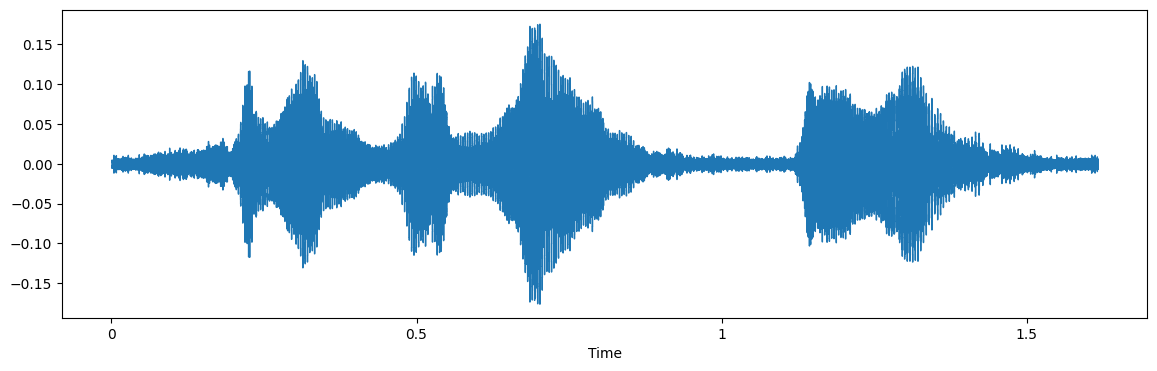

In [23]:
x = noise(data)
plt.figure(figsize=(14,4))
librosa.display.waveshow(y=x, sr=sample_rate)
Audio(x, rate=sample_rate)

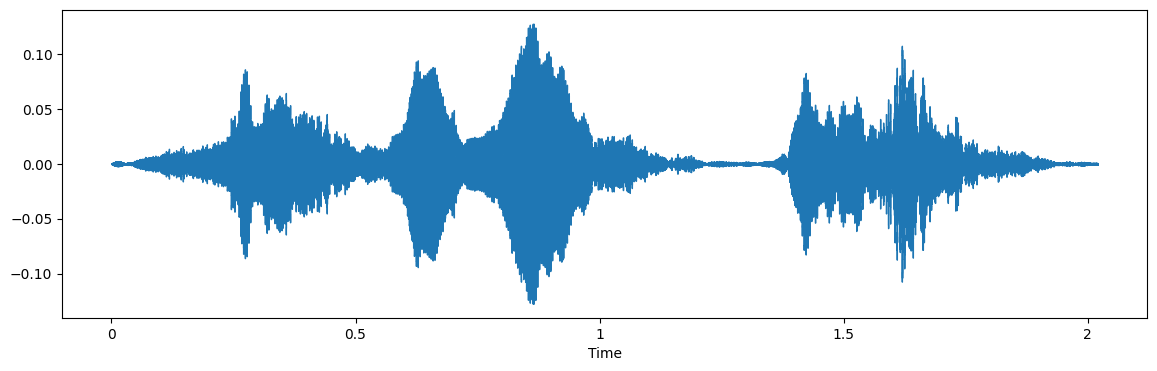

In [24]:
x = stretch(data)
plt.figure(figsize=(14,4))
librosa.display.waveshow(y=x, sr=sample_rate)
Audio(x, rate=sample_rate)

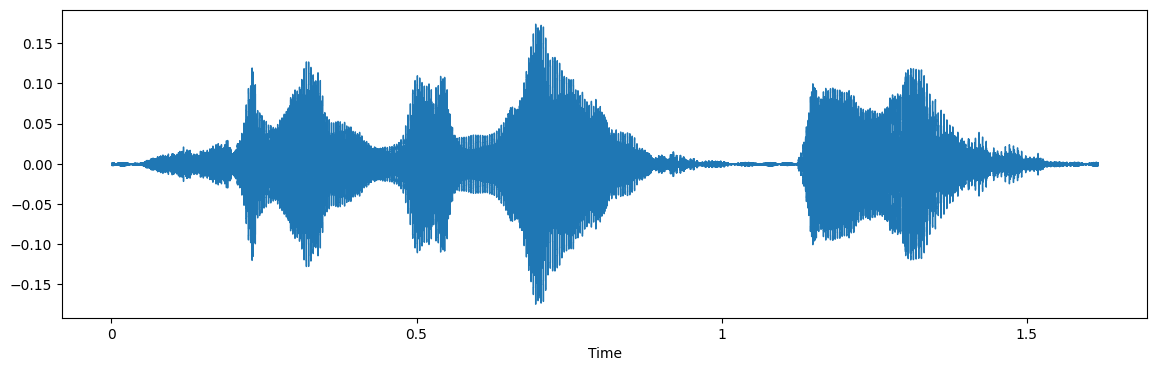

In [25]:
x = shift(data)
plt.figure(figsize=(14,4))
librosa.display.waveshow(y=x, sr=sample_rate)
Audio(x, rate=sample_rate)

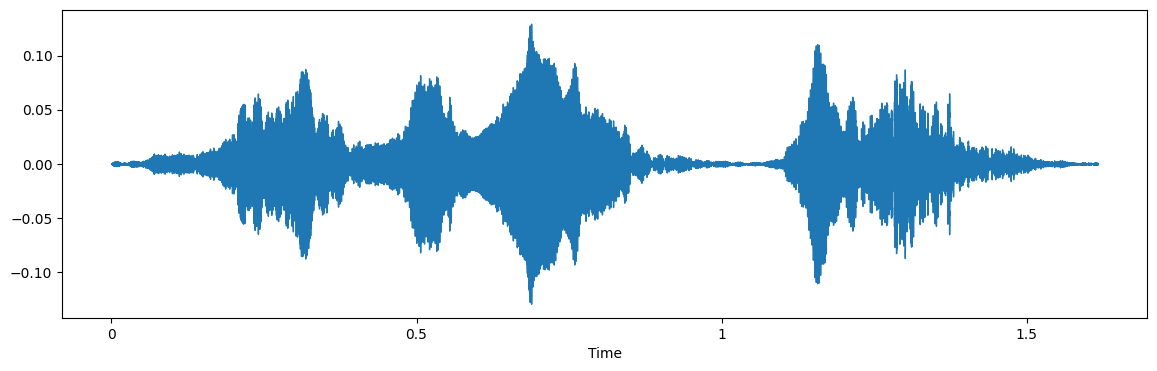

In [26]:
x = pitch(data, sample_rate)
plt.figure(figsize=(14,4))
librosa.display.waveshow(y=x, sr=sample_rate)
Audio(x, rate=sample_rate)


## Preprocessing

In [27]:
def extract_features(data):
    result = np.array([])
    # MFCC
    mfcc = np.mean(librosa.feature.mfcc(y=data, sr=sample_rate, n_mfcc=40).T, axis=0)
    result = np.hstack((result, mfcc)) # stacking horizontally

    return result


In [28]:
def get_features(path):
    # duration and offset are used to take care of the no audio in start and the ending of each audio files as seen above.
    data, sample_rate = librosa.load(path, duration=2.5, offset=0.6)

    # without augmentation
    res1 = extract_features(data)
    result = np.array(res1)

    # data with noise
    noise_data = noise(data)
    res2 = extract_features(noise_data)
    result = np.vstack((result, res2)) # stacking vertically

    # data with stretching and pitching
    new_data = stretch(data)
    data_stretch_pitch = pitch(new_data, sample_rate)
    res3 = extract_features(data_stretch_pitch)
    result = np.vstack((result, res3)) # stacking vertically

    return result

In [29]:
X, Y = [], []
for path, emotion in zip(df['path'], df['label']):
    print(path, emotion)
    feature = get_features(path)
    for ele in feature:
        X.append(ele)
        # appending emotion 3 times as we have made 3 augmentation techniques on each audio file.
        Y.append(emotion)

./Tess/OAF_angry\OAF_back_angry.wav angry
./Tess/OAF_angry\OAF_bar_angry.wav angry
./Tess/OAF_angry\OAF_base_angry.wav angry
./Tess/OAF_angry\OAF_bath_angry.wav angry
./Tess/OAF_angry\OAF_bean_angry.wav angry
./Tess/OAF_angry\OAF_beg_angry.wav angry
./Tess/OAF_angry\OAF_bite_angry.wav angry
./Tess/OAF_angry\OAF_boat_angry.wav angry
./Tess/OAF_angry\OAF_bone_angry.wav angry
./Tess/OAF_angry\OAF_book_angry.wav angry
./Tess/OAF_angry\OAF_bought_angry.wav angry
./Tess/OAF_angry\OAF_burn_angry.wav angry
./Tess/OAF_angry\OAF_cab_angry.wav angry
./Tess/OAF_angry\OAF_calm_angry.wav angry
./Tess/OAF_angry\OAF_came_angry.wav angry
./Tess/OAF_angry\OAF_cause_angry.wav angry
./Tess/OAF_angry\OAF_chain_angry.wav angry
./Tess/OAF_angry\OAF_chair_angry.wav angry
./Tess/OAF_angry\OAF_chalk_angry.wav angry
./Tess/OAF_angry\OAF_chat_angry.wav angry
./Tess/OAF_angry\OAF_check_angry.wav angry
./Tess/OAF_angry\OAF_cheek_angry.wav angry
./Tess/OAF_angry\OAF_chief_angry.wav angry
./Tess/OAF_angry\OAF_choice_

In [30]:
len(X), len(Y), df.path.shape

(8400, 8400, (2800,))

In [31]:
Features = pd.DataFrame(X)
Features['labels'] = Y
# Features.to_csv('features_tess.csv', index=False)
Features.head()

,0,1,2,3,4,5,6,7,8,9,...,31,32,33,34,35,36,37,38,39,labels
0,-398.608246,75.117401,-21.772625,-19.993965,2.985434,13.788046,-19.953243,-7.025359,-5.187742,1.833246,...,5.901571,9.498296,6.048397,1.720645,-2.132165,5.757223,9.964632,2.260837,-2.038578,angry
1,-216.329162,25.320670,-5.934436,-12.969209,-0.261710,2.980725,-4.586683,-5.853203,-2.667977,-0.150044,...,2.157450,4.301724,0.803046,-3.883702,-3.554374,3.029711,5.879788,2.687045,-2.334373,angry
2,-433.174683,45.838623,-52.567932,-5.295321,5.816541,-23.504416,2.893921,11.255253,1.060097,-0.203760,...,17.145664,9.896897,3.940851,2.917470,5.234529,-7.869997,-4.036841,9.037220,5.911855,angry
3,-469.633392,101.032448,1.475380,-32.444492,-9.686410,14.370925,-1.291309,-5.177819,-9.246143,5.867875,...,9.017988,13.152020,2.887668,2.447105,-1.420830,2.904995,9.037380,4.569520,3.737319,angry
4,-389.741704,64.624121,0.031808,-24.434478,-9.491444,7.637512,1.027339,-5.152227,-6.774993,-0.356150,...,7.322332,9.466263,1.976545,-0.725164,-2.272303,3.088403,6.822204,4.084559,2.099591,angry


In [32]:
X = Features.iloc[: ,:-1].values
Y = Features['labels'].values

In [33]:
encoder = OneHotEncoder()
Y = encoder.fit_transform(np.array(Y).reshape(-1,1)).toarray()

In [34]:
x_train, x_test, y_train, y_test = train_test_split(X, Y, random_state=0, shuffle=True)
x_train.shape, y_train.shape, x_test.shape, y_test.shape

((6300, 40), (6300, 7), (2100, 40), (2100, 7))

In [35]:
scaler = StandardScaler()
x_train = scaler.fit_transform(x_train)
x_test = scaler.transform(x_test)
x_train.shape, y_train.shape, x_test.shape, y_test.shape

((6300, 40), (6300, 7), (2100, 40), (2100, 7))

In [36]:
x_train = np.expand_dims(x_train, axis=2)
x_test = np.expand_dims(x_test, axis=2)
x_train.shape, y_train.shape, x_test.shape, y_test.shape

((6300, 40, 1), (6300, 7), (2100, 40, 1), (2100, 7))

## CNN Model

In [37]:
model=Sequential()
model.add(Conv1D(256, kernel_size=5, strides=1, padding='same', activation='relu', input_shape=(x_train.shape[1], 1)))
model.add(MaxPooling1D(pool_size=5, strides = 2, padding = 'same'))

model.add(Conv1D(256, kernel_size=5, strides=1, padding='same', activation='relu'))
model.add(MaxPooling1D(pool_size=5, strides = 2, padding = 'same'))
model.add(Dropout(0.2))

model.add(Conv1D(128, kernel_size=5, strides=1, padding='same', activation='relu'))
model.add(MaxPooling1D(pool_size=5, strides = 2, padding = 'same'))
model.add(Dropout(0.2))

model.add(Conv1D(64, kernel_size=5, strides=1, padding='same', activation='relu'))
model.add(MaxPooling1D(pool_size=5, strides = 2, padding = 'same'))
model.add(Dropout(0.2))

model.add(Flatten())
model.add(Dense(units=32, activation='relu'))
model.add(Dropout(0.3))

model.add(Dense(units=7, activation='softmax'))
model.compile(optimizer = 'adam' , loss = 'categorical_crossentropy' , metrics = ['accuracy'])

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 40, 256)           1536      
                                                                 
 max_pooling1d (MaxPooling1D  (None, 20, 256)          0         
 )                                                               
                                                                 
 conv1d_1 (Conv1D)           (None, 20, 256)           327936    
                                                                 
 max_pooling1d_1 (MaxPooling  (None, 10, 256)          0         
 1D)                                                             
                                                                 
 dropout (Dropout)           (None, 10, 256)           0         
                                                                 
 conv1d_2 (Conv1D)           (None, 10, 128)           1

In [38]:
rlrp = ReduceLROnPlateau(monitor='loss', factor=0.4, verbose=0, patience=2, min_lr=0.0000001)
history=model.fit(x_train, y_train, batch_size=64, epochs=50, validation_data=(x_test, y_test), callbacks=[rlrp])

Epoch 1/50
99/99 [==============================] - 5s 39ms/step - loss: 1.5018 - accuracy: 0.3892 - val_loss: 0.7518 - val_accuracy: 0.7457 - lr: 0.0010
Epoch 2/50
99/99 [==============================] - 4s 37ms/step - loss: 0.7630 - accuracy: 0.7349 - val_loss: 0.3583 - val_accuracy: 0.8905 - lr: 0.0010
Epoch 3/50
99/99 [==============================] - 4s 36ms/step - loss: 0.4830 - accuracy: 0.8368 - val_loss: 0.2122 - val_accuracy: 0.9252 - lr: 0.0010
Epoch 4/50
99/99 [==============================] - 4s 36ms/step - loss: 0.3852 - accuracy: 0.8770 - val_loss: 0.1863 - val_accuracy: 0.9429 - lr: 0.0010
Epoch 5/50
99/99 [==============================] - 4s 36ms/step - loss: 0.2513 - accuracy: 0.9194 - val_loss: 0.1143 - val_accuracy: 0.9543 - lr: 0.0010
Epoch 6/50
99/99 [==============================] - 4s 36ms/step - loss: 0.2230 - accuracy: 0.9260 - val_loss: 0.1401 - val_accuracy: 0.9557 - lr: 0.0010
Epoch 7/50
99/99 [==============================] - 3s 35ms/step - loss: 0.1

66/66 [==============================] - 0s 6ms/step - loss: 0.0433 - accuracy: 0.9924
Accuracy of our model on test data :  99.23809766769409 %


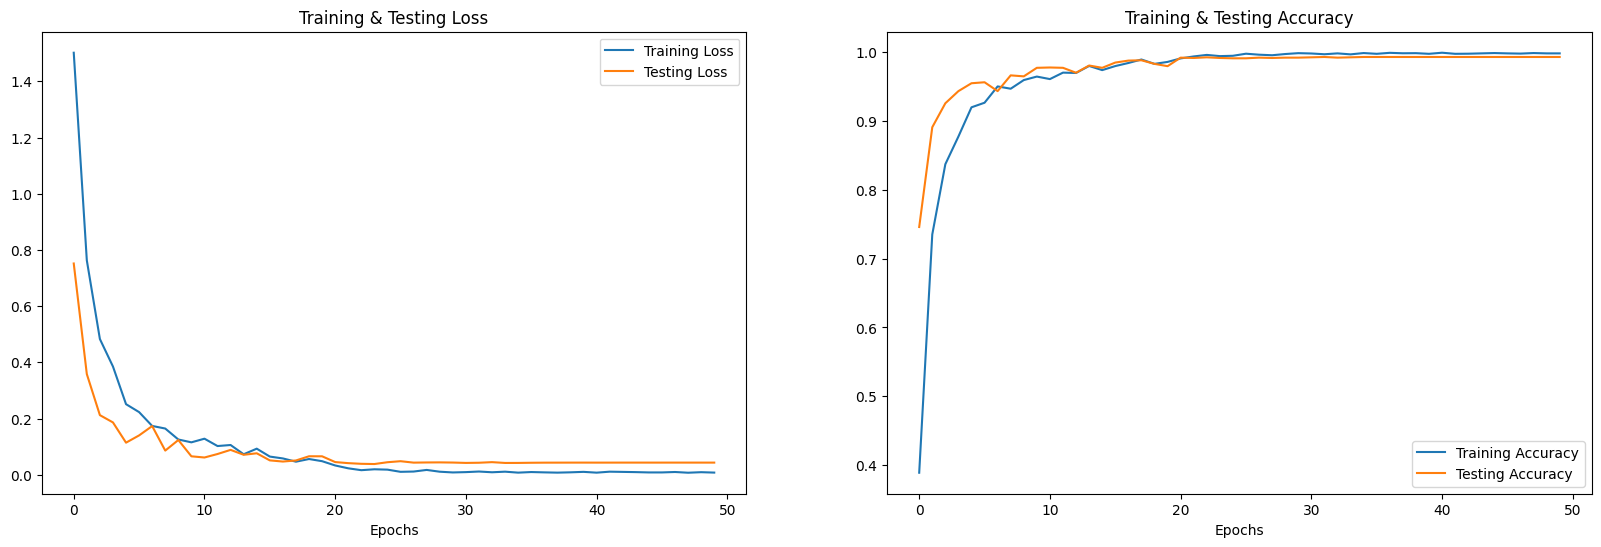

In [39]:
print("Accuracy of our model on test data : " , model.evaluate(x_test,y_test)[1]*100 , "%")

epochs = [i for i in range(50)]
fig , ax = plt.subplots(1,2)
train_acc = history.history['accuracy']
train_loss = history.history['loss']
test_acc = history.history['val_accuracy']
test_loss = history.history['val_loss']

fig.set_size_inches(20,6)
ax[0].plot(epochs , train_loss , label = 'Training Loss')
ax[0].plot(epochs , test_loss , label = 'Testing Loss')
ax[0].set_title('Training & Testing Loss')
ax[0].legend()
ax[0].set_xlabel("Epochs")

ax[1].plot(epochs , train_acc , label = 'Training Accuracy')
ax[1].plot(epochs , test_acc , label = 'Testing Accuracy')
ax[1].set_title('Training & Testing Accuracy')
ax[1].legend()
ax[1].set_xlabel("Epochs")
plt.show()

In [40]:
pred_test = model.predict(x_test)
y_pred = encoder.inverse_transform(pred_test)

y_test = encoder.inverse_transform(y_test)

66/66 [==============================] - 1s 6ms/step


In [41]:
output = pd.DataFrame(columns=['Predicted Labels', 'Actual Labels'])
output['Predicted Labels'] = y_pred.flatten()
output['Actual Labels'] = y_test.flatten()

output.head(10)

,Predicted Labels,Actual Labels
0,neutral,neutral
1,ps,ps
2,neutral,neutral
3,happy,happy
4,ps,ps
5,fear,fear
6,fear,fear
7,sad,sad
8,disgust,disgust
9,fear,fear


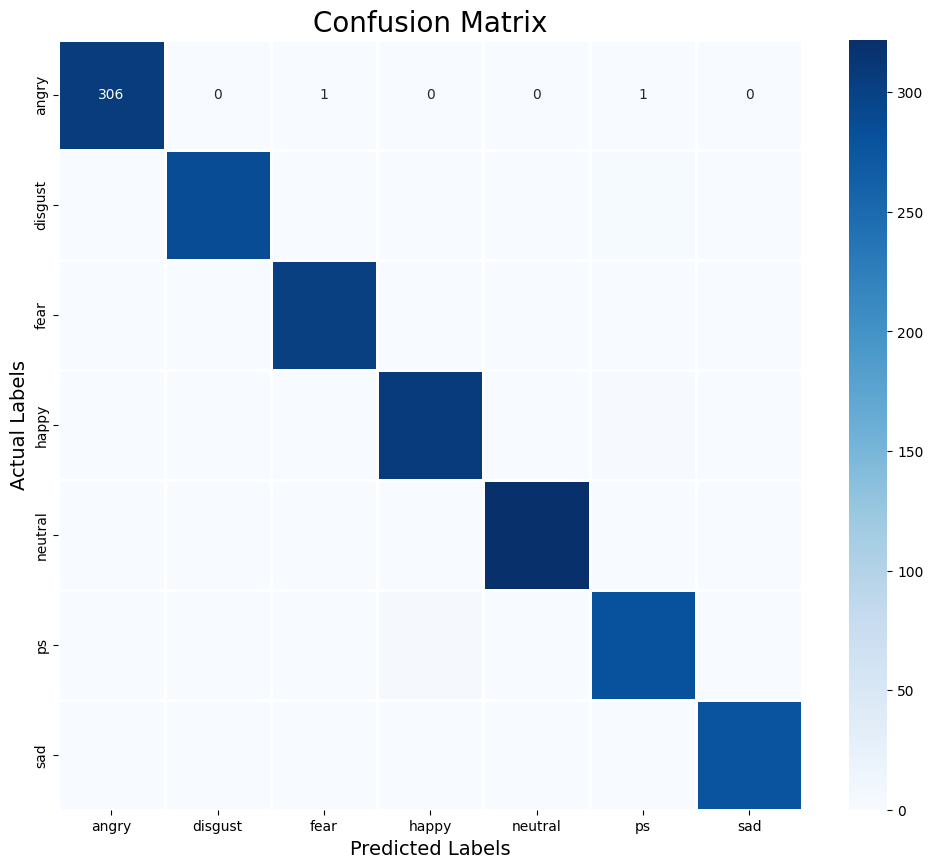

In [42]:
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize = (12, 10))
cm = pd.DataFrame(cm , index = [i for i in encoder.categories_] , columns = [i for i in encoder.categories_])
sns.heatmap(cm, linecolor='white', cmap='Blues', linewidth=1, annot=True, fmt='')
plt.title('Confusion Matrix', size=20)
plt.xlabel('Predicted Labels', size=14)
plt.ylabel('Actual Labels', size=14)
plt.show()

In [43]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

       angry       1.00      0.99      1.00       308
     disgust       0.99      0.99      0.99       291
        fear       1.00      1.00      1.00       303
       happy       0.99      0.99      0.99       310
     neutral       1.00      1.00      1.00       322
          ps       0.98      0.98      0.98       287
         sad       1.00      1.00      1.00       279

    accuracy                           0.99      2100
   macro avg       0.99      0.99      0.99      2100
weighted avg       0.99      0.99      0.99      2100



## LSTM Model

In [44]:
def extract_mfcc(filename):
    y, sr = librosa.load(filename, duration = 3, offset = 0.5)
    mfcc = np.mean(librosa.feature.mfcc(y = y, sr = sr, n_mfcc = 40).T, axis = 0)
    return mfcc

In [45]:
extract_mfcc(df['path'][0])

array([-3.9698630e+02,  7.7440544e+01, -1.9592793e+01, -2.1666689e+01,
       -2.1127563e+00,  1.0075363e+01, -2.0366709e+01, -6.0924492e+00,
       -7.2122831e+00, -5.5736595e-01, -1.8325537e+00,  2.0210202e-01,
        7.2755092e-01,  1.3177378e+00,  2.8863375e+00,  2.8557916e+00,
       -4.7129192e+00, -4.4365101e+00, -1.6211587e+00, -1.0239840e+01,
       -7.5512633e+00, -1.7968794e+00, -7.0376520e+00,  9.4365845e+00,
        8.3558540e+00,  2.1712360e+01,  1.9216990e+01,  2.0348928e+01,
        1.3413368e+01,  8.3391733e+00,  3.9472228e-01,  5.1113148e+00,
        9.5687399e+00,  5.4548688e+00,  2.5099635e+00, -1.8239068e+00,
        4.8689623e+00,  9.3139238e+00,  2.0891497e+00, -1.9064908e+00],
      dtype=float32)

In [46]:
X_mfcc = df['path'].apply(lambda x: extract_mfcc(x))

In [47]:
X = [x for x in X_mfcc]
X = np.array(X)
X.shape

(2800, 40)

In [48]:
X = np.expand_dims(X, -1)
X.shape

(2800, 40, 1)

In [49]:
enc = OneHotEncoder()
y = enc.fit_transform(df[['label']])

In [50]:
y = y.toarray()

In [51]:
y.shape

(2800, 7)

In [52]:
x_train, x_test, y_train, y_test = train_test_split(X, y, random_state=0, shuffle=True)

In [53]:
model = Sequential([
    LSTM(256, return_sequences=False, input_shape=(40,1)),
    Dropout(0.2),
    Dense(128, activation='relu'),
    Dropout(0.2),
    Dense(64, activation='relu'),
    Dropout(0.2),
    Dense(32, activation = 'relu'),
    Dropout(0.3),
    Dense(7, activation='softmax')
])

model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 256)               264192    
                                                                 
 dropout_4 (Dropout)         (None, 256)               0         
                                                                 
 dense_2 (Dense)             (None, 128)               32896     
                                                                 
 dropout_5 (Dropout)         (None, 128)               0         
                                                                 
 dense_3 (Dense)             (None, 64)                8256      
                                                                 
 dropout_6 (Dropout)         (None, 64)                0         
                                                                 
 dense_4 (Dense)             (None, 32)               

In [54]:
checkpoint_filepath = 'best_model.keras'
model_checkpoint_callback = ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_best_only=True,
    monitor='val_accuracy',
    mode='max',
    verbose=1)


def scheduler(epoch, lr):
    if epoch < 10:
        return lr
    else:
        return lr * tf.math.exp(-0.1)

lr_scheduler_callback = LearningRateScheduler(scheduler)

history = model.fit(x_train, y_train, validation_split=0.2, epochs=50, batch_size=64)

Epoch 1/50
27/27 [==============================] - 5s 103ms/step - loss: 1.6266 - accuracy: 0.2994 - val_loss: 1.1248 - val_accuracy: 0.5524
Epoch 2/50
27/27 [==============================] - 2s 89ms/step - loss: 1.0896 - accuracy: 0.5661 - val_loss: 0.6404 - val_accuracy: 0.7881
Epoch 3/50
27/27 [==============================] - 2s 89ms/step - loss: 0.7481 - accuracy: 0.7226 - val_loss: 0.5628 - val_accuracy: 0.7690
Epoch 4/50
27/27 [==============================] - 2s 88ms/step - loss: 0.6144 - accuracy: 0.7899 - val_loss: 0.3728 - val_accuracy: 0.8881
Epoch 5/50
27/27 [==============================] - 2s 87ms/step - loss: 0.4475 - accuracy: 0.8464 - val_loss: 0.2079 - val_accuracy: 0.9190
Epoch 6/50
27/27 [==============================] - 2s 88ms/step - loss: 0.4002 - accuracy: 0.8756 - val_loss: 0.1501 - val_accuracy: 0.9452
Epoch 7/50
27/27 [==============================] - 2s 87ms/step - loss: 0.2890 - accuracy: 0.9077 - val_loss: 0.1081 - val_accuracy: 0.9571
Epoch 8/50
2

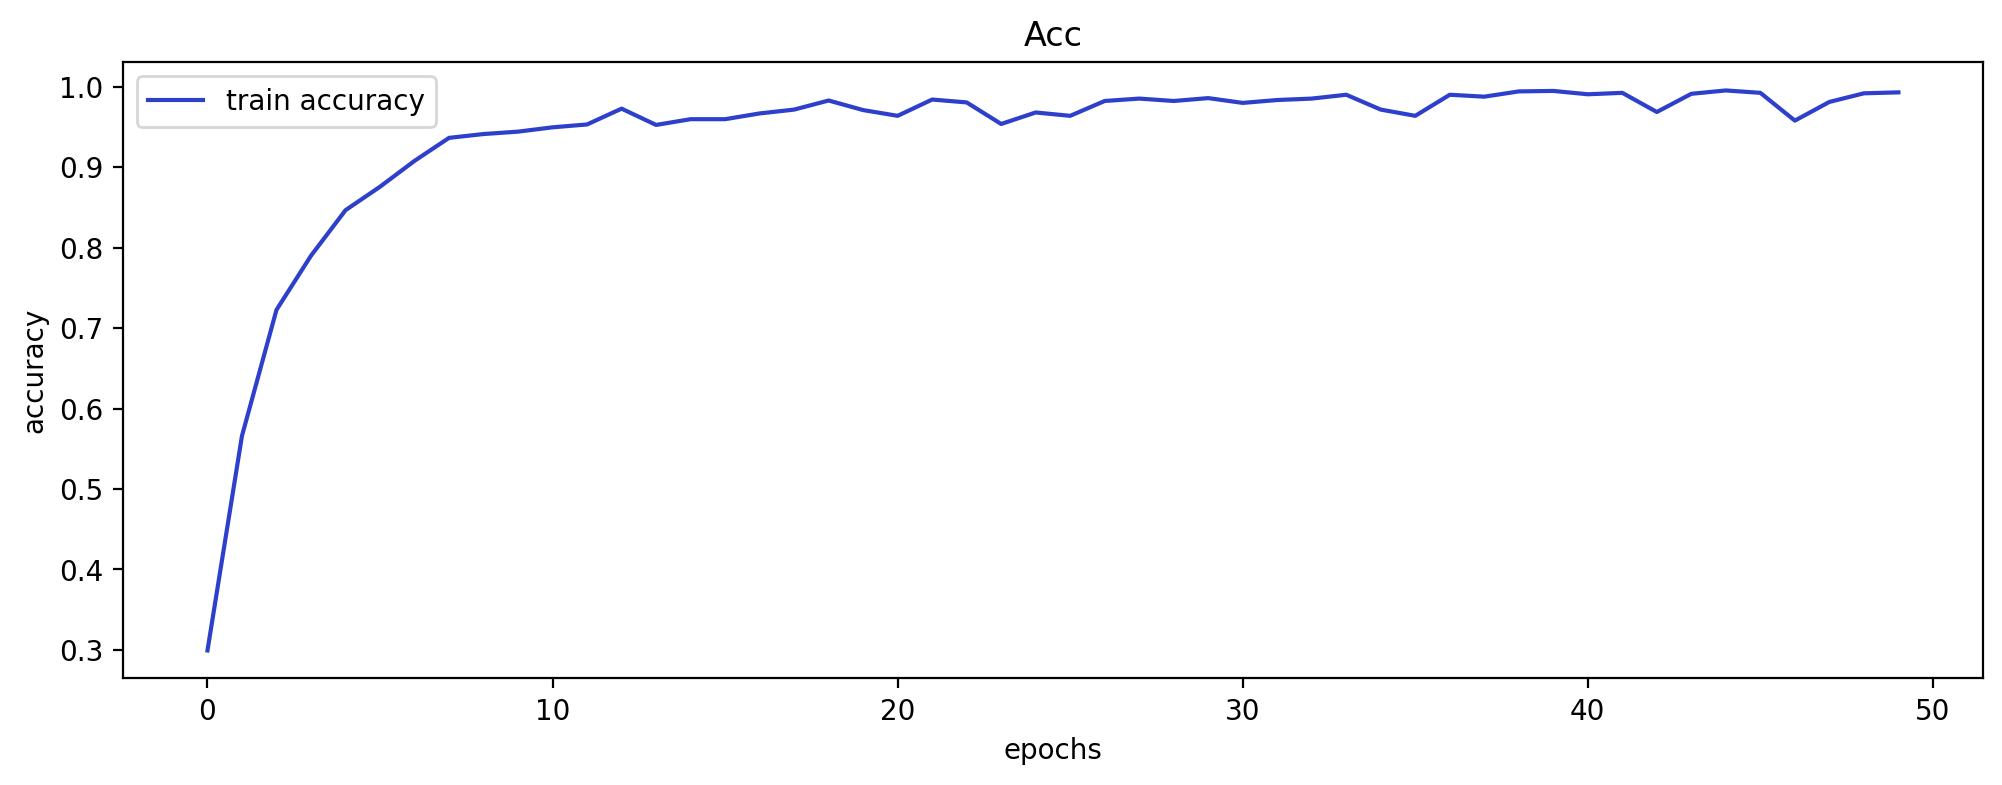

In [55]:
epochs = list(range(50))
acc = history.history['accuracy']

plt.figure(figsize=(12, 4), dpi=200)
plt.plot(epochs, acc, label='train accuracy', color='#2E40CB')
plt.xlabel('epochs')
plt.ylabel('accuracy')
plt.title('Acc')
plt.legend()
plt.show()

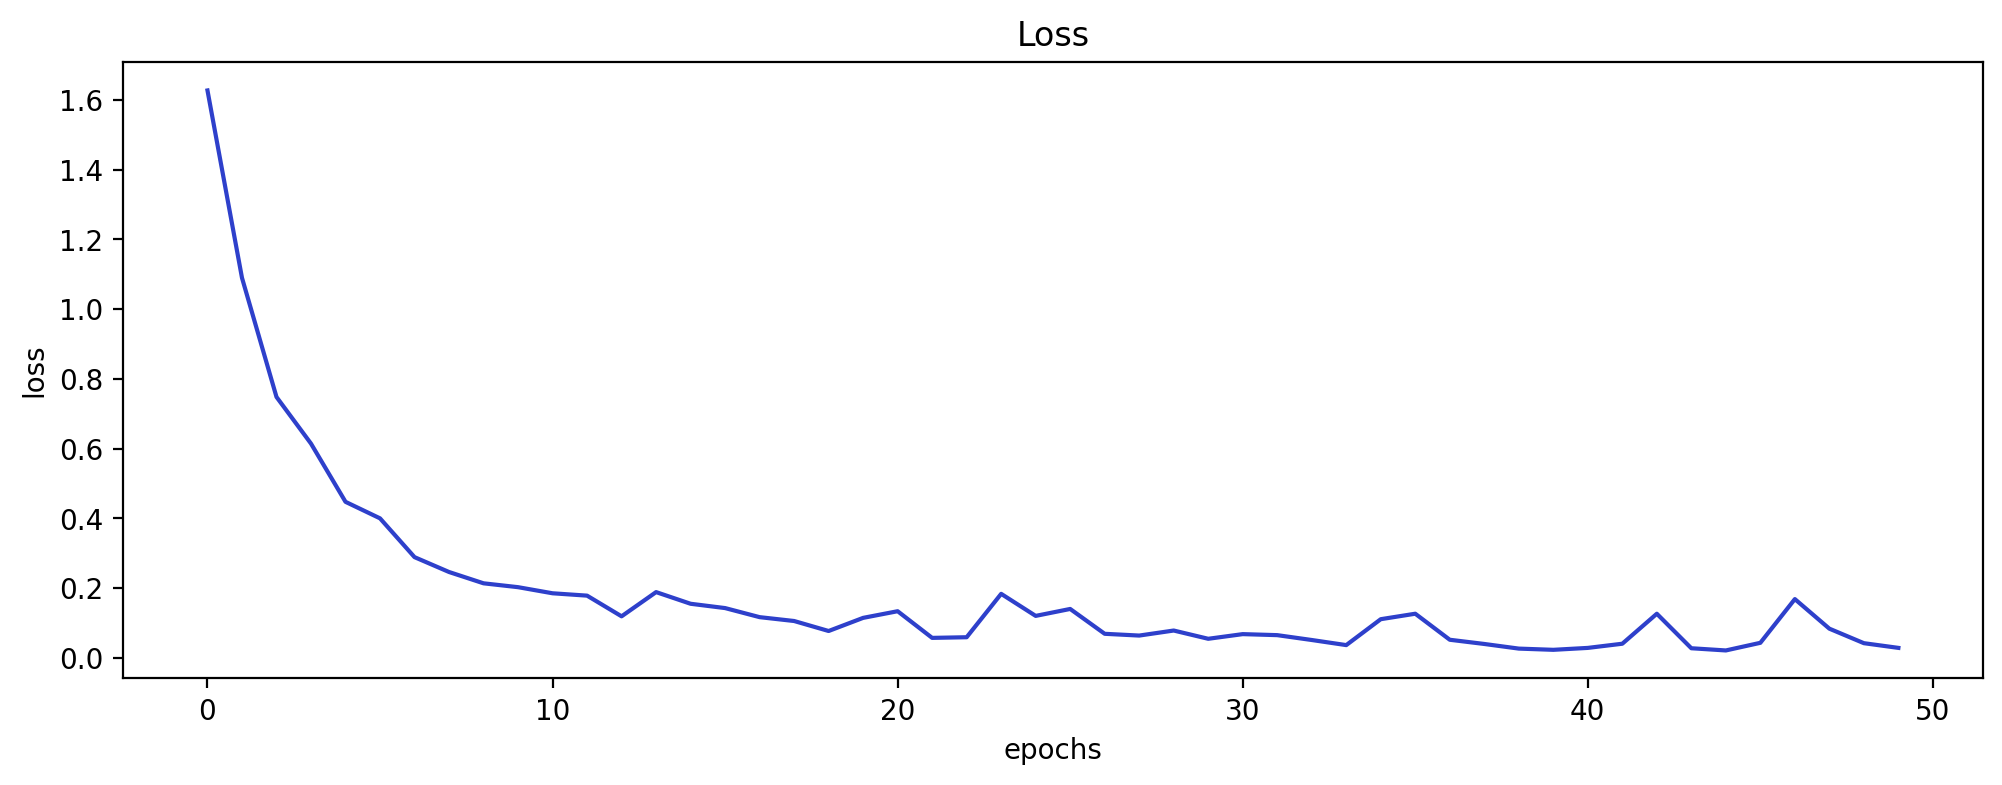

In [56]:
loss = history.history['loss']

plt.figure(figsize=(12, 4), dpi=200)
plt.plot(epochs, loss, label='train loss', color='#2E40CB')
plt.xlabel('epochs')
plt.ylabel('loss')
plt.title('Loss')
plt.show()

In [57]:
test_loss, test_accuracy = model.evaluate(x_test, y_test, verbose=2)
print(f'Test Accuracy: {test_accuracy}')

22/22 - 1s - loss: 0.0696 - accuracy: 0.9843 - 518ms/epoch - 24ms/step
Test Accuracy: 0.9842857122421265
